In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Importing necessary libraries

In [2]:
#importing the necessary libraries
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from tabulate import tabulate

from pandas.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Loading the dataset

In [4]:
train = "/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv"
test = "/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv"
data = pd.read_csv(train)
df_test = pd.read_csv(test)


# Load the data
# train_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
# test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

In [5]:
data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


# Exploratory Data Analysis (EDA)

### Exploring the Dataset

In [6]:
# data.isnull().sum()

In [7]:
# Statistical summary of Categorical columns 
cat_summary = data.describe(include=['object'])
print("\nStatistical summary of categorical columns:")
print(tabulate(cat_summary, headers='keys', tablefmt='fancy_grid'))


Statistical summary of categorical columns:
╒════════╤═════════════════════╤═════════════╤═══════════╤═════════════╤═══════════╤═══════════╤════════╤═══════════╤════════════╤══════════╕
│        │ last contact date   │ job         │ marital   │ education   │ default   │ housing   │ loan   │ contact   │ poutcome   │ target   │
╞════════╪═════════════════════╪═════════════╪═══════════╪═════════════╪═══════════╪═══════════╪════════╪═══════════╪════════════╪══════════╡
│ count  │ 39211               │ 38982       │ 39211     │ 37744       │ 39211     │ 39211     │ 39211  │ 28875     │ 9760       │ 39211    │
├────────┼─────────────────────┼─────────────┼───────────┼─────────────┼───────────┼───────────┼────────┼───────────┼────────────┼──────────┤
│ unique │ 1013                │ 11          │ 3         │ 3           │ 2         │ 2         │ 2      │ 2         │ 3          │ 2        │
├────────┼─────────────────────┼─────────────┼───────────┼─────────────┼───────────┼───────────┼───────

In [8]:
# Statistical summary of numerical columns 
num_summary = data.describe(include=['int64'])
print("\nStatistical summary of numerical columns:")
print(tabulate(num_summary, headers='keys', tablefmt='fancy_grid'))


Statistical summary of numerical columns:
╒═══════╤════════════╤═══════════╤════════════╤═════════════╤════════════╤════════════╕
│       │        age │   balance │   duration │    campaign │      pdays │   previous │
╞═══════╪════════════╪═══════════╪════════════╪═════════════╪════════════╪════════════╡
│ count │ 39211      │  39211    │  39211     │ 39211       │ 39211      │ 39211      │
├───────┼────────────┼───────────┼────────────┼─────────────┼────────────┼────────────┤
│ mean  │    42.1202 │   5441.78 │    439.063 │     5.10877 │    72.2561 │    11.8262 │
├───────┼────────────┼───────────┼────────────┼─────────────┼────────────┼────────────┤
│ std   │    12.7094 │  16365.3  │    769.096 │     9.89015 │   160.943  │    44.1403 │
├───────┼────────────┼───────────┼────────────┼─────────────┼────────────┼────────────┤
│ min   │    18      │  -8019    │      0     │     1       │    -1      │     0      │
├───────┼────────────┼───────────┼────────────┼─────────────┼────────────┼───

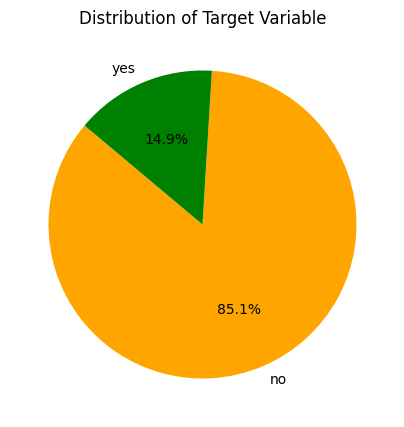

In [9]:
target_counts = data['target'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140, colors=['orange', 'green'])
plt.title("Distribution of Target Variable")
plt.show()

*Inferences on Target Variable:*

* *Imbalanced Target Distribution* - Majority (85.1%) fall into the "no" category, meaning they did not subscribe to the bank's term deposit. Only 14.9% of clients subscribed, indicated by the "yes" category.
* *Challenge for Predictive Modeling* - If you're using this dataset to predict whether a client will subscribe, the imbalance could make it challenging for models to predict the minority class ("yes"). Handling this imbalance might require techniques like resampling (oversampling/undersampling) or using algorithms with class weighting
* *Campaign Effectiveness Insight* - The low percentage of "yes" responses suggests that a relatively small proportion of clients are subscribing, which could imply that the telemarketing campaigns have limited effectiveness. This could prompt further analysis into improving targeting strategies or adjusting campaign tactics to reach a more receptive audience.

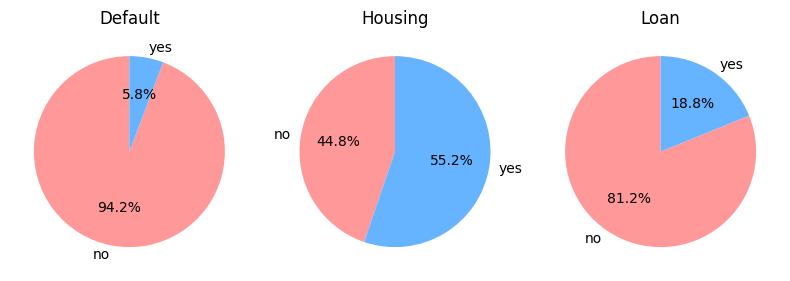

In [10]:
columns = ['default', 'housing', 'loan']  
value_counts_dict = {}

# Getting the value counts for each column and storing in a dictionary
for col in columns:
    value_counts_dict[col] = data[col].value_counts()

value_counts_df = pd.DataFrame(value_counts_dict)
value_counts_df.fillna(0, inplace=True)  

# Plot pie charts in a tight layout
plt.figure(figsize=(8, 3))  # figure size
for i, col in enumerate(columns, 1):
    plt.subplot(1, len(columns), i)  # Create a subplot for each column
    value_counts_df[col].plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], legend=False)
    plt.title(col.capitalize())
    plt.ylabel('')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

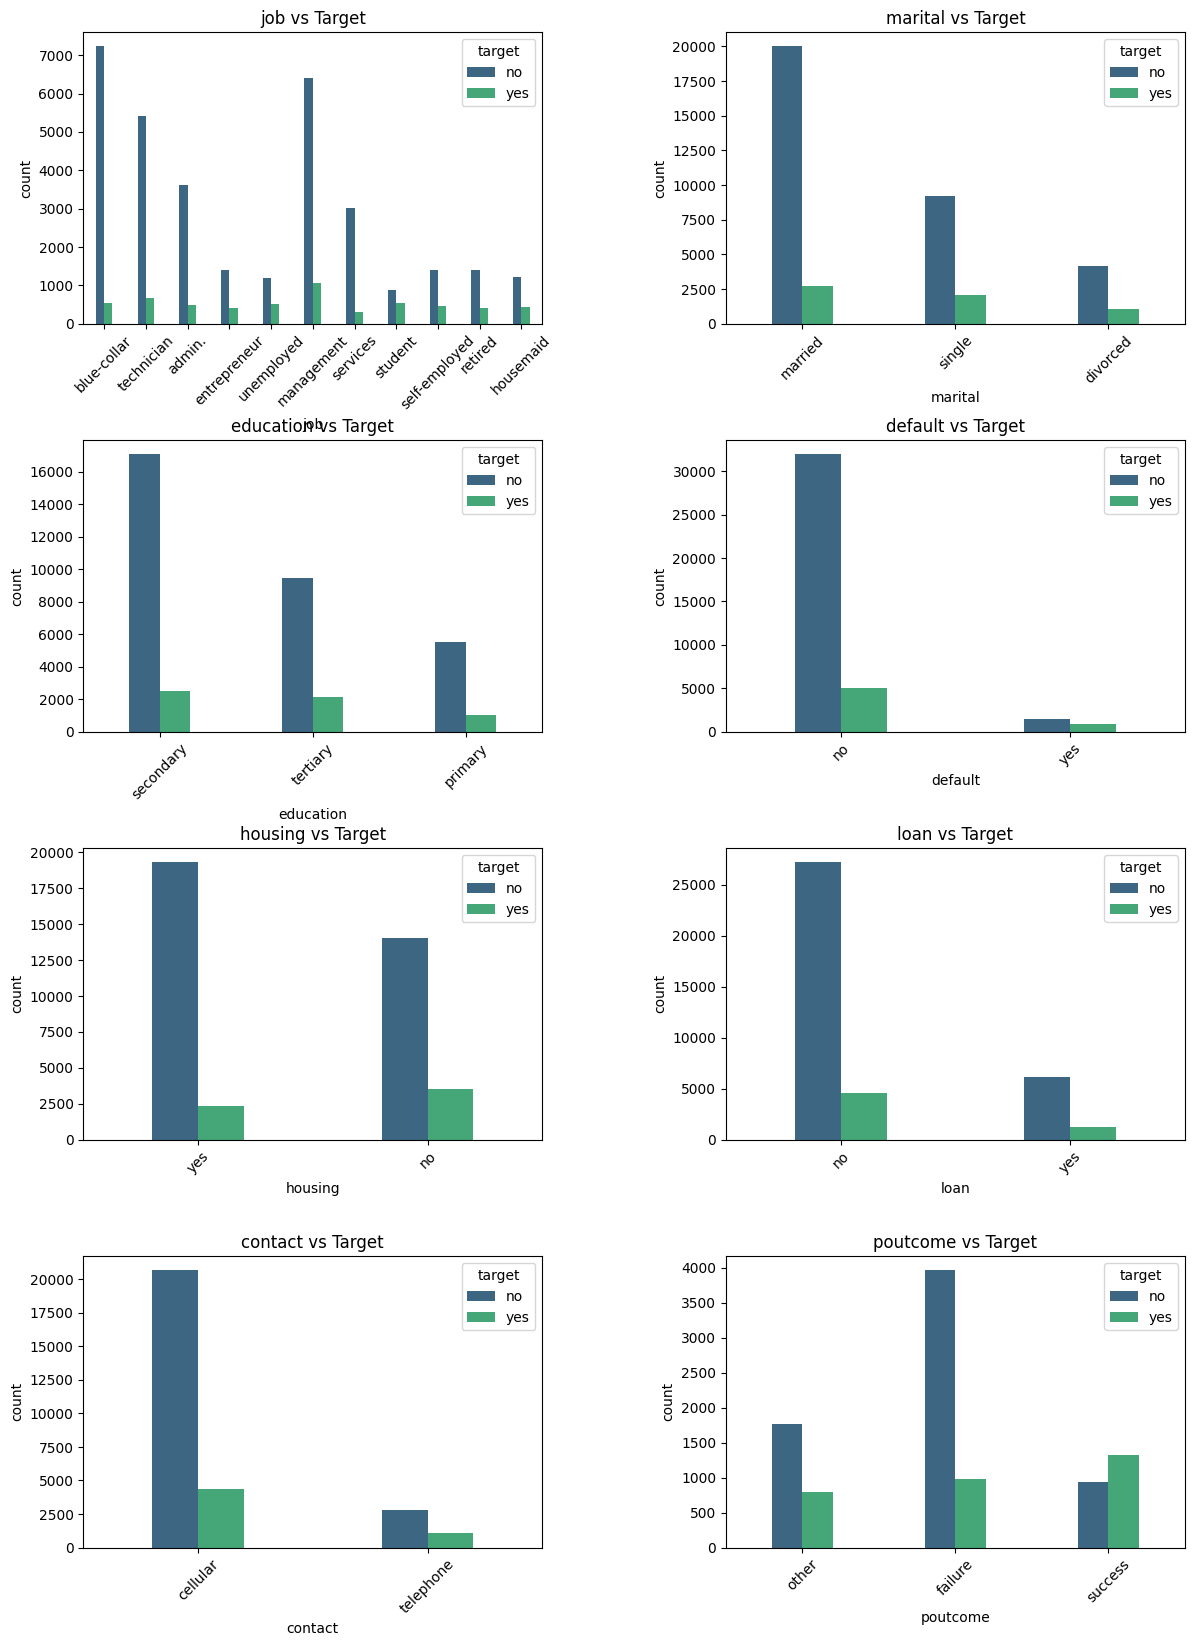

In [11]:
# Specifying the categorical columns directly
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Set up a grid layout for compact plotting
fig, axes = plt.subplots(nrows=len(categorical) // 2 + len(categorical) % 2, ncols=2, figsize=(12, len(categorical) * 2))
fig.tight_layout(pad=2)

# Iterate over categorical columns and plot each in a subplot
for i, col in enumerate(categorical):
    ax = axes[i // 2, i % 2]  # Determine the position in the grid
    sns.countplot(x=col, hue='target', data=data, palette='viridis', width=0.4, ax=ax)
    ax.set_title(f"{col} vs Target")
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

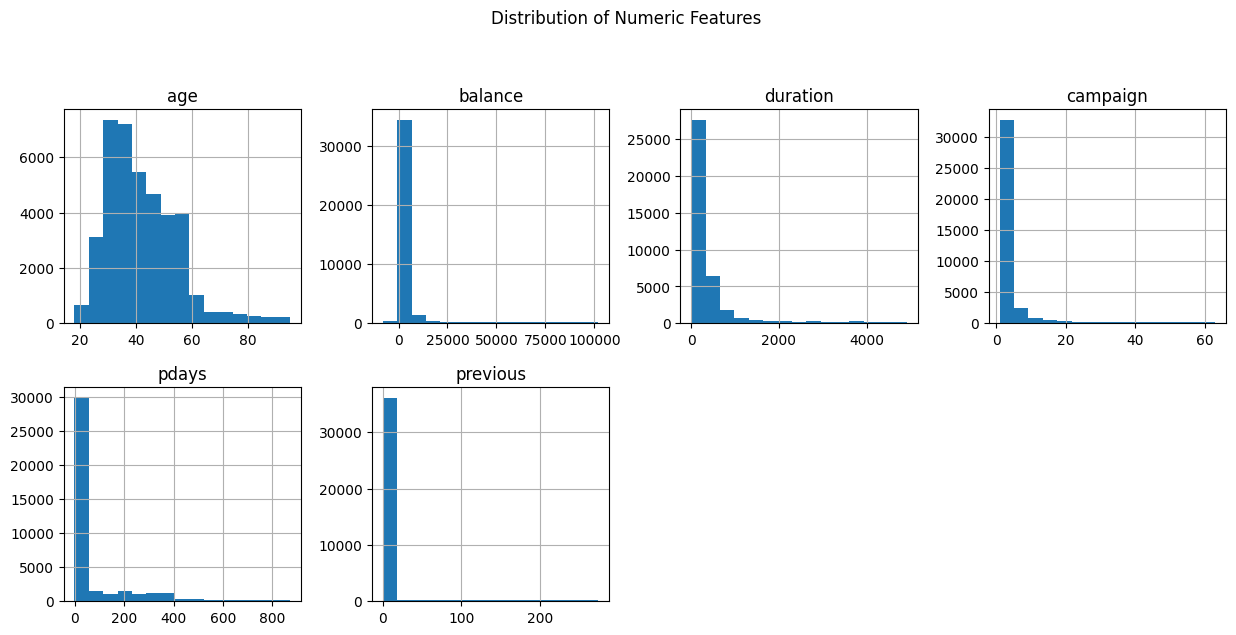

In [12]:
numeric = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric].hist(bins=15, figsize=(15, 10), layout=(3, 4))
plt.suptitle("Distribution of Numeric Features")
plt.show()

Inferences :

1. *Age :* The distribution is approximately normal, with most customers between 20 and 60 years old. This indicates a diverse age range, though the majority are middle-aged.
2. *Balance :* The distribution is highly right-skewed. Most customers have a low account balance, with a few customers holding significantly higher balances.
3. *Duration :* This feature also shows a right-skewed distribution. Most interactions are brief, but a few last much longer, possibly indicating varied engagement levels or responsiveness among customers.
4. *Campaign :* The distribution is right-skewed, with most customers contacted only a few times during the campaign. Very few customers have a high contact frequency, suggesting a focused campaign strategy.
5. *pdays :* This shows number of days that passed by after the client was last contacted from a previous campaign. There’s a heavy concentration at zero, suggesting that many customers were not contacted in previous campaigns. The right tail represents a small group contacted long after previous campaigns.
6. *previous :* It shows the number of contacts performed before this campaign and for this client. Similar to *pdays*, most customers have zero past contacts, with only a few having multiple prior interactions. This could indicate either a low retention rate or a targeted approach for returning customers.

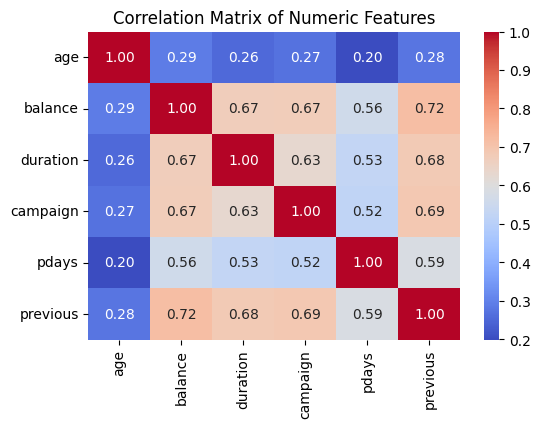

In [13]:
# Checking correlations between numeric features and the target
plt.figure(figsize=(6, 4))
correlation_matrix = data[numeric].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

Based on the correlation heatmap, here are some insights about the relationships between numeric features in this dataset:

1. **Strong Positive Correlations**    - **`previous` and `balance` (0.72)**: There is a strong positive correlation between `previous` and `balance`, suggesting that clients with higher previous engagements with the bank tend to have higher account balances.  - **`duration` and `balance` (0.67)**: Higher `balance` is associated with longer call `duration`, possibly indicating that clients with higher balances are more engaged during calls.   - **`campaign` and `balance` (0.67)**: Clients who participate in more `campaign` calls also have higher balanc
2. **Moderate Positive Correlations**ti   :
   - **`previous` and `duration` (0.68)**: Clients with a history of previous engagements also tend to have longer call duratis.
   - **`pdays` and `balance` (0.56)**: Clients who were contacted more recently (`pdays` closer to zero) tend to have higher balaes.
   - **`campaign` and `duration` (0.63)**: Clients called multiple times (`campaign`) tend to spend more time on eachall.
   - **`previous` and `campaign` (0.69)**: There’s a moderate positive correlation between `previous` contacts and the number of calls in a campaign, indicating that clients with previous engagements may receive more follo
   w-3p calls.

3. **Weak to Moderate Correlations withage`**:
   - `age` has weak to moderate positive correlations with other features, such as `balance` (0.29) and `previous` (0.28), suggesting that age has only a mild association with 
   th5se factors.

4. **Low Correlation Values (ar 0.2)**:
   - **`age` and `pdays` (0.20)**: There’s a weak correlation between `age` and `pdays`, indicating little relationship between a client's age and how recently the
   y 7ere contacted.

5. **Implications for Featu Selection**:
   - High correlations between features like `balance`, `duration`, and `previous` may indicate multicollinearity, so careful consideration is needed in model building, as redundant features could add noise rath
   er than information.

This correlation matrix provides insight into client behavior patterns related to telemarketing campaigns, particularly suggesting that `balance`, `duration`, and `previous` interactions are significant indicators of client engagement.

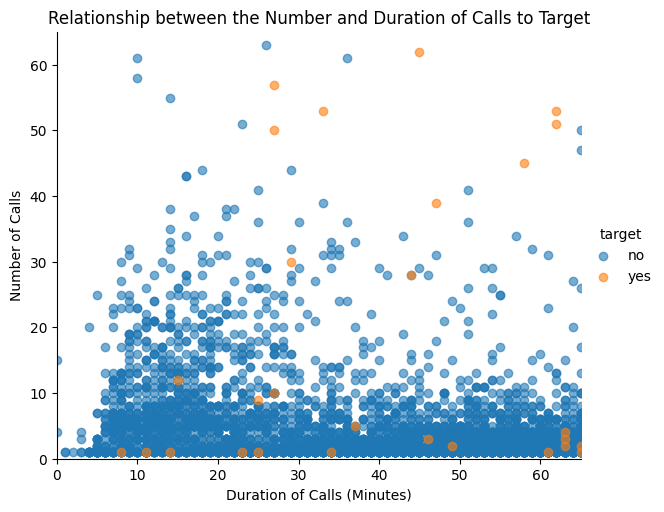

In [14]:
dur_cam = sns.lmplot(x='duration', y='campaign',data=data,
                     hue = 'target',fit_reg = False, aspect = 1.2,
                     scatter_kws={'alpha':0.6}, height = 5)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('Relationship between the Number and Duration of Calls to Target')

plt.show()

##### Analysing the Numerical columns to look for outliers and their contribution in the dataset

While most column have outliers we cannot do much with them because they are important for our dataset as removing them is interfering with the accuracy while employing the ML Models like Random Forest and XGBoost.

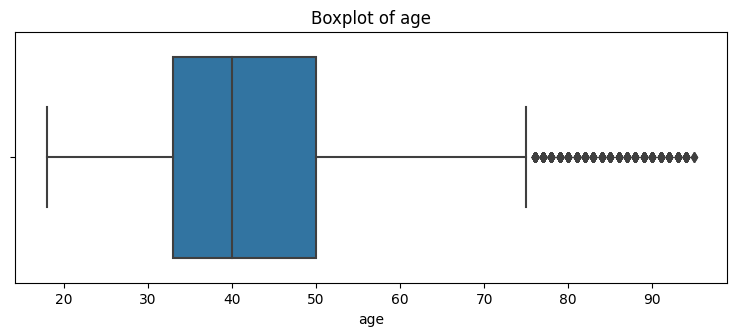

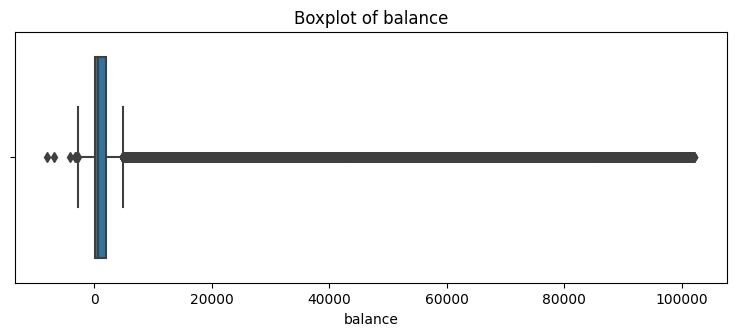

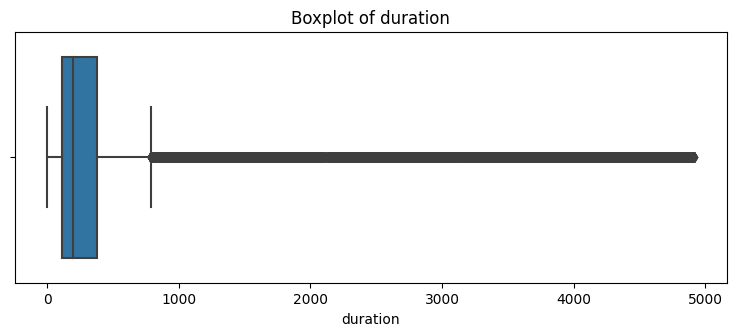

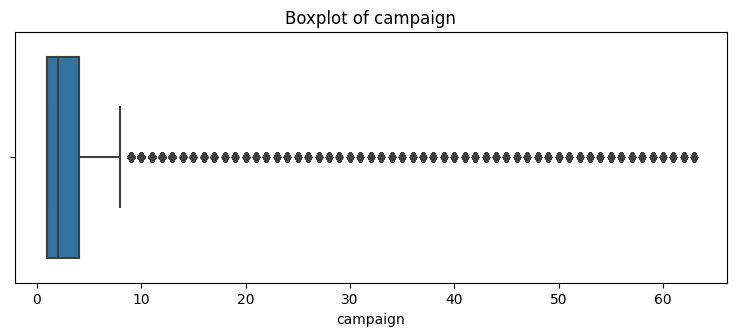

In [15]:
numeric = ['age','balance','duration','campaign']

for col in numeric:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout(pad = 3)
    plt.show()

##### Feature Engineering of the "last_contact_date" column

It is to help us get the month and the day in which the Bank contacted the customer to sell a service/product.

In [16]:
data['last contact date'] = pd.to_datetime(data['last contact date'], format='%Y-%m-%d')
df_test['last contact date'] = pd.to_datetime(df_test['last contact date'])
data['day'] = data['last contact date'].dt.day_name()
data['month'] = data['last contact date'].dt.month_name()

cols = data.columns.tolist()
data = data.iloc[:, [-2, -1] + list(range(0, len(cols)-2))]

data.drop(columns=['last contact date'], inplace=True)

In [17]:
data.head()

,day,month,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,Friday,April,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,Sunday,October,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,Saturday,November,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,Tuesday,September,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,Tuesday,January,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


#### Month-wise success rate

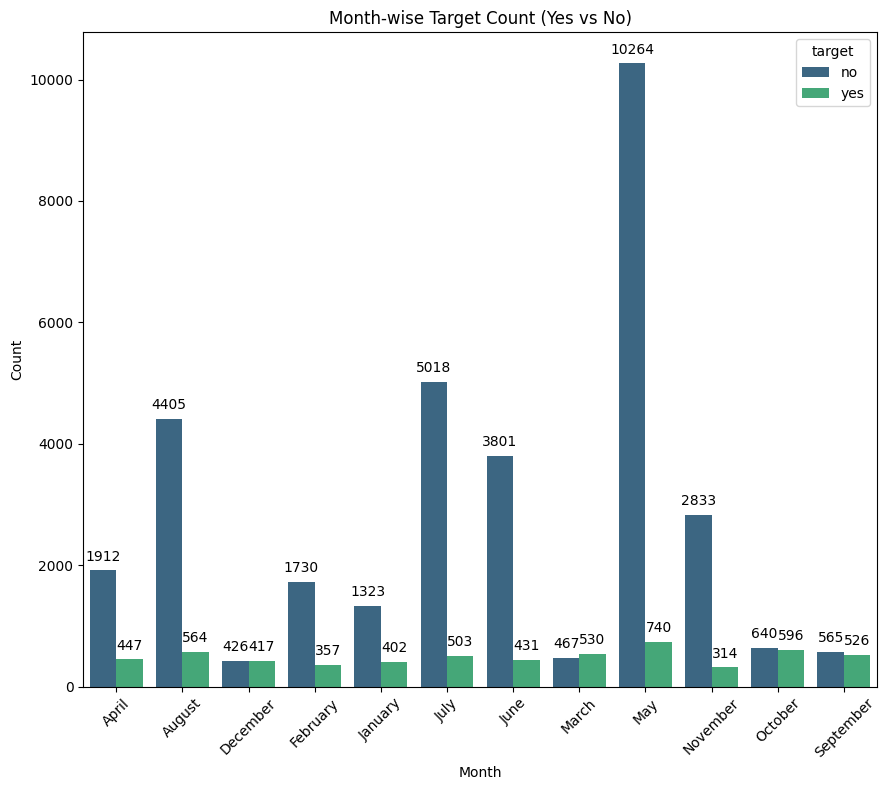

In [18]:
month_target_counts = data.groupby(['month', 'target']).size().reset_index(name='count')

plt.figure(figsize=(9, 8))
barplot = sns.barplot(x='month', y='count', hue='target', data=month_target_counts, palette='viridis')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 10), 
                     textcoords = 'offset points')

plt.title('Month-wise Target Count (Yes vs No)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
month_target_counts = data.groupby(['month', 'target']).size().unstack(fill_value=0)
month_target_dict = month_target_counts.to_dict(orient='index')

print(month_target_dict)

{'April': {'no': 1912, 'yes': 447}, 'August': {'no': 4405, 'yes': 564}, 'December': {'no': 426, 'yes': 417}, 'February': {'no': 1730, 'yes': 357}, 'January': {'no': 1323, 'yes': 402}, 'July': {'no': 5018, 'yes': 503}, 'June': {'no': 3801, 'yes': 431}, 'March': {'no': 467, 'yes': 530}, 'May': {'no': 10264, 'yes': 740}, 'November': {'no': 2833, 'yes': 314}, 'October': {'no': 640, 'yes': 596}, 'September': {'no': 565, 'yes': 526}}


In [20]:
month_target_counts = data.groupby(['month', 'target']).size().unstack(fill_value=0)
month_target_normalized = month_target_counts.div(month_target_counts.sum(axis=1), axis=0)

month_target_normalized = month_target_normalized.round(3)

month_target_normalized_dict = month_target_normalized.to_dict(orient='index')
print(month_target_normalized_dict)

{'April': {'no': 0.811, 'yes': 0.189}, 'August': {'no': 0.886, 'yes': 0.114}, 'December': {'no': 0.505, 'yes': 0.495}, 'February': {'no': 0.829, 'yes': 0.171}, 'January': {'no': 0.767, 'yes': 0.233}, 'July': {'no': 0.909, 'yes': 0.091}, 'June': {'no': 0.898, 'yes': 0.102}, 'March': {'no': 0.468, 'yes': 0.532}, 'May': {'no': 0.933, 'yes': 0.067}, 'November': {'no': 0.9, 'yes': 0.1}, 'October': {'no': 0.518, 'yes': 0.482}, 'September': {'no': 0.518, 'yes': 0.482}}


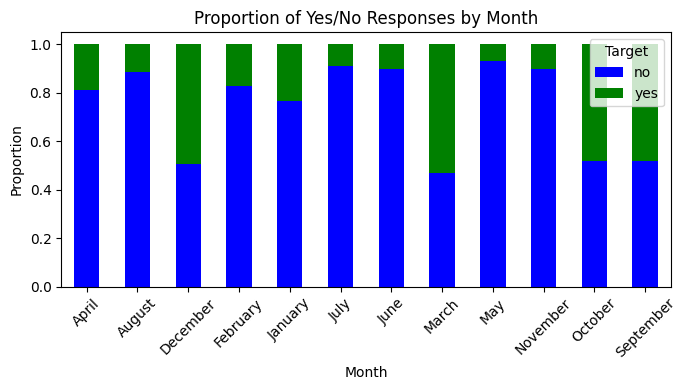

In [21]:
month_target_normalized.plot(kind='bar', stacked=True, figsize=(7, 4), color=['blue', 'green'])
plt.title('Proportion of Yes/No Responses by Month')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

##### Inference :

The months of December, March, October and September show more number of people signing up for the subscription from the Bank, therefore we cannot drop the month column as it is contributing significantly to the outcome of service.

### Day-wise Success Rate

In the following analysis and plotting we can see that there is no much variation in the day-wise success rate. Any day of the week faces failure rates within the range : 0.876 to 0.807 and the success rate ranges from : 0.193 to 0.123. Therefore this feature can be dropped as it does not have a considerable degree of influence on the outcome of the dataset.

On dropping this feature and running the Random Forest Classifier it was noted that the model was dropping in accuracy in both validation and test datasets, therefore the feature was not removed at the end. 

In [22]:
day_target_counts = data.groupby(['day', 'target']).size().unstack(fill_value=0)
day_target_dict = day_target_counts.to_dict(orient='index')

print(day_target_dict)

{'Friday': {'no': 5929, 'yes': 833}, 'Monday': {'no': 3257, 'yes': 776}, 'Saturday': {'no': 3919, 'yes': 577}, 'Sunday': {'no': 2435, 'yes': 581}, 'Thursday': {'no': 6463, 'yes': 965}, 'Tuesday': {'no': 5169, 'yes': 1015}, 'Wednesday': {'no': 6212, 'yes': 1080}}


In [23]:
day_target_counts = data.groupby(['day', 'target']).size().unstack(fill_value=0)
day_target_normalized = day_target_counts.div(day_target_counts.sum(axis=1), axis=0)

day_target_normalized = day_target_normalized.round(3)

day_target_normalized_dict = day_target_normalized.to_dict(orient='index')
print(day_target_normalized_dict)

{'Friday': {'no': 0.877, 'yes': 0.123}, 'Monday': {'no': 0.808, 'yes': 0.192}, 'Saturday': {'no': 0.872, 'yes': 0.128}, 'Sunday': {'no': 0.807, 'yes': 0.193}, 'Thursday': {'no': 0.87, 'yes': 0.13}, 'Tuesday': {'no': 0.836, 'yes': 0.164}, 'Wednesday': {'no': 0.852, 'yes': 0.148}}


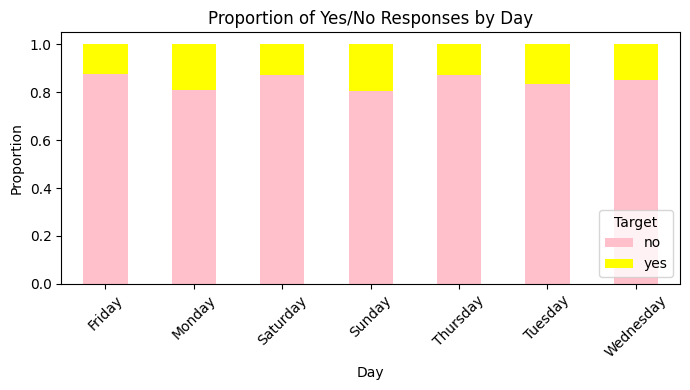

In [24]:
# Plot a stacked bar chart
day_target_normalized.plot(kind='bar', stacked=True, figsize=(7, 4), color=['pink', 'yellow'])
plt.title('Proportion of Yes/No Responses by Day')
plt.xlabel('Day')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Target', loc='lower right')
plt.tight_layout()
plt.show()

# Preprocessing 

In [25]:
data_x=data.drop('target',axis=1)
data_y=data['target']

In [26]:
data_x.head()

,day,month,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,Friday,April,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other
1,Sunday,October,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN
2,Saturday,November,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN
3,Tuesday,September,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN
4,Tuesday,January,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN


In [27]:
num = data_x.select_dtypes(exclude = 'object').columns
cat = data_x.select_dtypes(include = 'object').columns

print(cat)
print(num)

Index(['day', 'month', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'poutcome'],
      dtype='object')
Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


## Constructing the Pipelines

In [28]:
numeric = Pipeline(steps = [
    ("mean",SimpleImputer(strategy = "mean")),
    ("scaler",StandardScaler())
])
categorical = Pipeline(steps = [
    ("mode",SimpleImputer(strategy = "most_frequent")),
    ("ohe",OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))
])

ordinal_day = Pipeline(steps = [
    ("mode", SimpleImputer(strategy = "most_frequent")),
    ("ordinal_day", OrdinalEncoder(categories = [['Sunday','Monday','Tuesday','Wednesday',
                                                  'Thursday','Friday','Saturday']],unknown_value = -1,handle_unknown = "use_encoded_value"))
])

ordinal_month = Pipeline(steps = [
    ("mode", SimpleImputer(strategy = "most_frequent")),
    ("ordinal_month", OrdinalEncoder(categories = [['January','February','March','April','May',
                                                    'June','July','August','September',
                                                    'October','November','December']],unknown_value = -1,handle_unknown = "use_encoded_value"))
])
ordinal_education = Pipeline(steps = [
    ("mode", SimpleImputer(strategy = "most_frequent")),
    ("ordinal_education", OrdinalEncoder(categories = [['primary','secondary','tertiary']],unknown_value = -1,handle_unknown = "use_encoded_value"))
])
transformer = ColumnTransformer(transformers = [
    ("numeric",numeric,num),
    ("categorical",categorical,['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']),
    ("ordinal_day", ordinal_day,['day']),
    ("ordinal_month",ordinal_month,['month']),
    ("ordinal_education",ordinal_education,['education'])
],remainder = "passthrough").set_output(transform = "pandas")
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('mean', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                spars...
                                                                              'September',
                                                                              'October',
                                                                              'November',
                                                                              'December']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['month']),
                                ('ordinal_education',
                                 Pipeline(steps=[('mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal_education',
                                                  OrdinalEncoder(categories=[['primary',
                                                                              'secondary',
                                                                              'tertiary']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['education'])])

## Splitting the dataset into Train and Validation

In [29]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size = 0.01, random_state = 42, stratify = data_y)
print(X_train.shape)
print(X_val.shape)

(38818, 16)
(393, 16)


In [30]:
X_train_t = transformer.fit_transform(X_train)
X_val_t = transformer.transform(X_val)

# Model Training 

## Logistic Regression

In [31]:
# log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
# log_reg.fit(X_train_t, y_train)

# y_pred = log_reg.predict(X_val_t)
# score = f1_score(y_val, y_pred, average='macro', labels=["yes"])
# print("LR_Score:", score)

# # LR_Score: 0.539522367978473 (while the day column was dropped)
# # LR_Score: 0.5945945945945945 (when 0.01 as validation set)

## Support Vector Classifier (SVC)

In [32]:
svc = SVC (class_weight="balanced",random_state = 42, kernel = 'rbf', 
           max_iter = -1, decision_function_shape = 'ovr', verbose = 0)
svc.fit(X_train_t, y_train)

y_pred = svc.predict(X_val_t)
score = f1_score(y_val, y_pred, average = "macro",labels = "yes")
print("SVC_score:", score)

SVC_score: 0.7724241214057508


## XGBoost Classifier

In [33]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

xgb_clf = XGBClassifier(n_estimators=1700, learning_rate=0.01, max_depth=7, gamma = 1,random_state=42,
                        min_child_weight = 2, subsample = 0.8, colsample_bytree = 0.8,
                        use_label_encoder=False, eval_metric='mlogloss'
)


xgb_clf.fit(X_train_t, y_train_encoded)


y_pred = xgb_clf.predict(X_val_t)
score = f1_score(y_val_encoded, y_pred, average='macro')
print("XGB_Score:", score)

# XGB_Score: 0.7457641115989704 (1800 , val_set = 0.01)

XGB_Score: 0.7423795476892823


## Random Forest Classifier

In [34]:
classifier = RandomForestClassifier (n_estimators = 1200, max_depth = 25, 
                                     min_samples_split = 6, min_samples_leaf = 4,
                                     bootstrap = True, oob_score = True, 
                                     n_jobs = -1, random_state = 42, 
                                     verbose = 0, class_weight="balanced_subsample")
classifier.fit(X_train_t, y_train)

y_pred = classifier.predict(X_val_t)
score = f1_score(y_val, y_pred, average = "macro",labels = "yes")
print("RFC_score:", score)

# RFC_score: 0.8168685927306617 (val_set = 0.01, 950 with or without default column, anything beyond 0.01 is dropping the score by >50%)

RFC_score: 0.8200951742199227


## Voting Classifier

In [35]:
# from sklearn.ensemble import VotingClassifier 
# le = LabelEncoder()

# y_train_encoded = le.fit_transform(y_train)
# y_val_encoded = le.transform(y_val)

# # Create individual models
# rf_clf = RandomForestClassifier(n_estimators=1200, max_depth=25, 
#                                 min_samples_split=6, min_samples_leaf=4, 
#                                 random_state=42, bootstrap = True,
#                                 oob_score = True, class_weight = "balanced_subsample")

# xgb_clf = XGBClassifier(n_estimators=1700, learning_rate=0.01, max_depth=7, 
#                         gamma = 1,random_state=42,min_child_weight = 2, 
#                         subsample = 0.8, colsample_bytree = 0.8,
#                         use_label_encoder=False, eval_metric='mlogloss')

# svc = SVC(class_weight = "balanced", random_state = 42, kernel = 'rbf', C = 1e-2,
#           degree = 3, gamma = 'scale', coef0 = 0.0, shrinking = True, probability = True,
#           tol = 1e-3, cache_size = 200, verbose = False, max_iter = -1,
#           decision_function_shape = 'ovr')

# # Voting Classifier (Hard Voting)
# voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('svc', svc)],
#                               voting='hard',n_jobs=-1 ) 

# # Fit the ensemble model
# voting_clf.fit(X_train_t, y_train_encoded)

# # Predict and evaluate
# y_pred = voting_clf.predict(X_val_t)
# score = f1_score(y_val_encoded, y_pred, average='macro')
# print("Voting Ensemble F1 Score:", score)

# # Voting Ensemble F1 Score: 0.7358955634040055 (no change)
# # Voting Ensemble F1 Score: 0.8261831048208758 

In [36]:
# from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Predict and evaluate
# y_pred = voting_clf.predict(X_val_t)
# score = f1_score(y_val_encoded, y_pred, average='macro')
# print("Voting Ensemble F1 Score:", score)

# # Generate the confusion matrix
# conf_matrix = confusion_matrix(y_val_encoded, y_pred)

# # Display the confusion matrix
# print("Confusion Matrix:\n", conf_matrix)

# # Optionally, visualize the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
# disp.plot(cmap=plt.cm.Blues)
# plt.show()

In [37]:
# # Voting Classifier (Hard Voting)
# voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('svc', svc)],
#                               voting='hard',n_jobs=-1 ) 

# # Fit the ensemble model
# voting_clf.fit(X_train_t, y_train_encoded)

# # Get feature importances
# feature_importances = pd.Series(VotingClassifier.feature_importances_, index = X_train_t.columns)

# # Sort and plot
# feature_importances.sort_values().plot(kind='barh', color='green', figsize=(10, 8))
# plt.title('Feature Importance')
# plt.xlabel('Importance Score')
# plt.show()

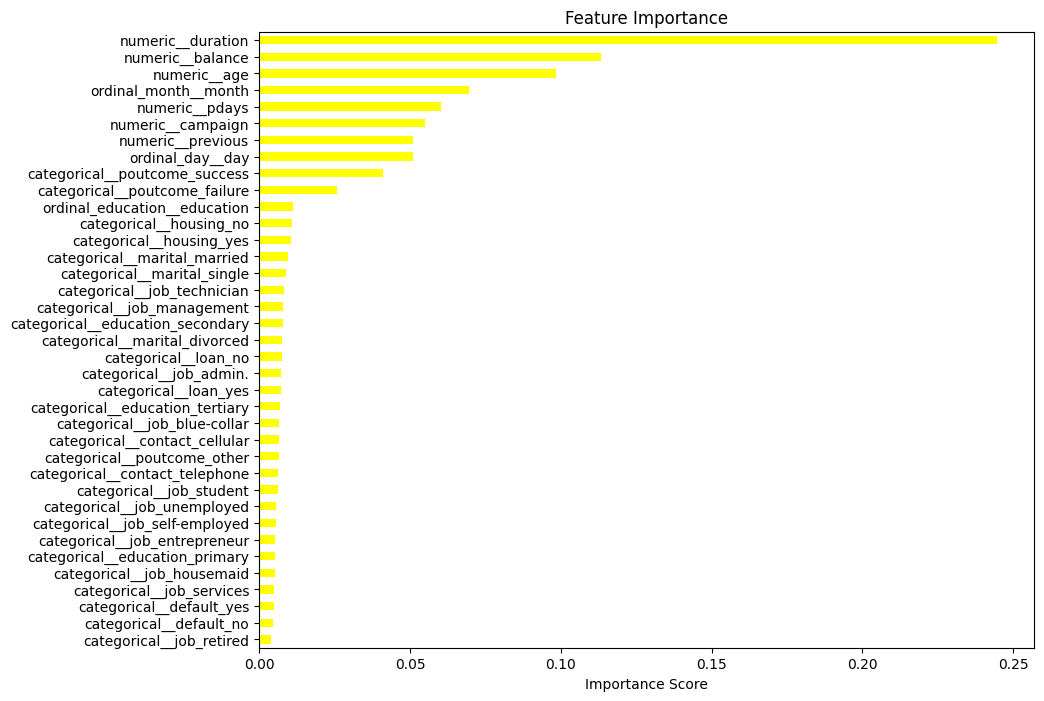

In [38]:
# Assuming X_train and y_train are your training data and target variable
model = RandomForestClassifier()
model.fit(X_train_t, y_train)

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index = X_train_t.columns)

# Sort and plot
feature_importances.sort_values().plot(kind='barh', color='yellow', figsize=(10, 8))
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

# Hyper-parameter tuning for Random Forest Classifier 

## Random Forest Classifier using GridSearchCV

In [39]:
rf_param_grid = {
    'n_estimators': [900, 920],
    'max_depth': [25, 30],
    'min_samples_split': [2, 6]
    ,'min_samples_leaf': [4, 6],
#     'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, 
                              scoring='f1_macro', cv=3, verbose = 2)

In [40]:
# grid_search_rf.fit(X_train_t, y_train)

# print(f"Best Random Forest Params: {grid_search_rf.best_params_}")
# print(f"Best Random Forest F1 Score: {grid_search_rf.best_score_}")

In [41]:
# best_rf = grid_search_rf.best_estimator_
# y_pred = best_rf.predict(X_val_t)

# f1 = f1_score(y_val, y_pred, average='macro', labels=["yes"])
# print("F1 Score on Validation Set:", f1)

# # Best Random Forest Params: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 850}

# # Best Random Forest F1 Score: 0.6850983569026159
# # F1 Score on Validation Set: 0.49589322381930184

# Comparing the scores of ML Models Employed

In [42]:
# SVC = 0.72809 - test_set
# SVC_score: 0.73444 - val_set

# XGBoost = 0.7107 - test_set
# XGB_Score = 0.7292 - val_set

# RFC = 0.7608 - test_set
# RFC_score = 0.7673 - val_set

# Voting_Ensemble = 0.7201 test_set
# Voting_Ensemble_Score = 0.7359 val_set(hard)

# Decision Tree = 0.4598 - val_set
# Decision_Tree_Score = 0.3925 - test_set

# Logistic Regression = 0.5395 - val_set
# Logistic Regression = 0.5102 - test_set

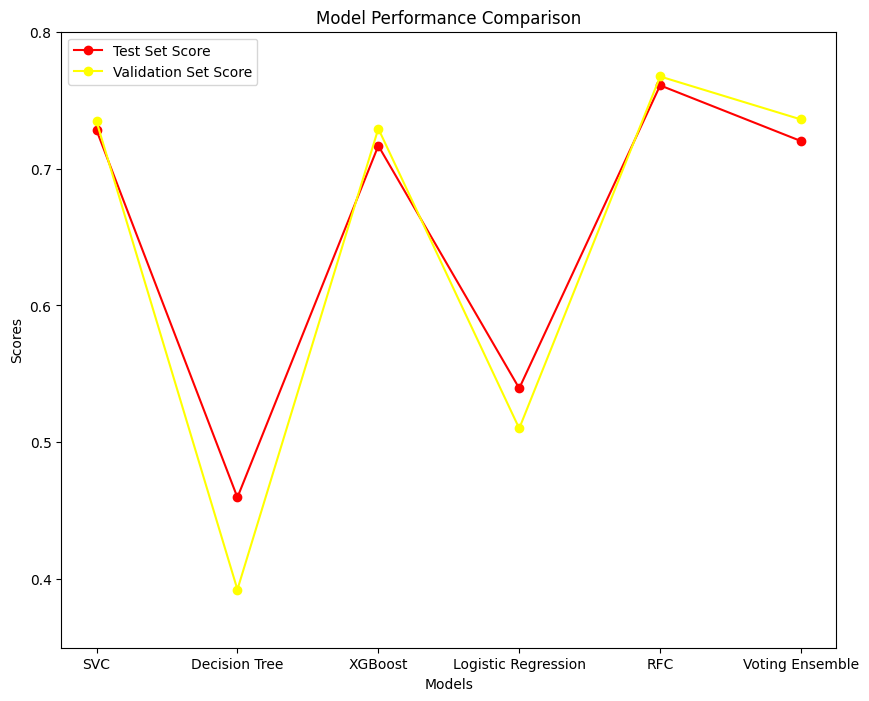

In [43]:
models = ['SVC','Decision Tree', 'XGBoost','Logistic Regression', 'RFC', 'Voting Ensemble']
test_set_scores = [0.72809, 0.4598, 0.7167, 0.5395, 0.7608, 0.7201]
val_set_scores = [0.73444, 0.3925, 0.7292, 0.5102, 0.7673, 0.7359]

# Plotting the lines
plt.figure(figsize=(10, 8))
plt.plot(models, test_set_scores, marker='o', color='red', label='Test Set Score')
plt.plot(models, val_set_scores, marker='o', color='yellow', label='Validation Set Score')

# Adding titles and labels
plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.ylim(0.35, 0.8)  # Setting y-axis limits for better visualization
plt.legend()

plt.show()

##### Inferences on Model Performance :

1. *Support Vector Classifier (SVC)* - SVC shows a small difference between the validation and test set performance, suggesting it generalizes well on unseen data, though the validation set score is slightly better, which is common due to tuning on validation data.
2. *XG Boost (XGB)* - XGBoost shows a noticeable drop in performance on the test set compared to the validation set. This could indicate overfitting to the validation set or that it hasn't generalized as well to unseen data.
3. *Random Forest Classifier (RFC)* - Random Forest has relatively consistent performance between the validation and test sets, indicating good generalization. The small drop suggests it is not overfitting much, which is a good sign.
4. *Voting Ensemble* - The voting ensemble also performs well, but there is a slight drop in performance on the test set. This indicates that while ensemble methods are often robust, their performance can vary slightly based on how they aggregate predictions from individual models.
5. *Decision Tree and Logistic Regression* - The decision tree performs poorly overall, with a significant drop from the validation set to the test set. This suggests that the decision tree model is either overfitting to the validation set or not generalizing well to the test set.
Logistic regression also shows a small decrease in performance on the test set compared to the validation set, indicating that it might have slightly overfitted the validation data but overall, its performance is quite low compared to other models.

##### General Inferences :

Since it shows the most consistent and high performance, Random Forest might be the most reliable model here. It is the only model which crosses the prescribed cut-off score of 0.75, thus the model employed here is Random Forest.

# Preparing the Test dataset

In [44]:
df_test = pd.read_csv(test)

In [45]:
df_test['last contact date'] = pd.to_datetime(df_test['last contact date'], format='%Y-%m-%d')
df_test['day'] = df_test['last contact date'].dt.day_name()

df_test['month'] = df_test['last contact date'].dt.month_name()

In [46]:
cols = df_test.columns.tolist()
df_test = df_test.iloc[:, [-2, -1] + list(range(0, len(cols)-2))]

df_test.drop(columns=['last contact date'], inplace=True)
df_test.head()

,day,month,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,Saturday,November,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,Thursday,February,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,Wednesday,July,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,Wednesday,June,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,Sunday,March,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [47]:
# df_test = transformer.transform(df_test)

## Latest Model 

In [48]:
# Load the data
train_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

# Data Preprocessing
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'])
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'])

In [49]:
# Extract features from 'last contact date'
for df in [train_df, test_df]:
    df['contact_year'] = df['last contact date'].dt.year
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_day'] = df['last contact date'].dt.day
    df['contact_dayofweek'] = df['last contact date'].dt.dayofweek
    df.drop('last contact date', axis=1, inplace=True)

# Handle missing values
for col in ['job', 'education', 'contact', 'poutcome']:
    train_df[col] = train_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

In [50]:
# Encode categorical variables using one-hot encoding
train_df_encoded = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])
test_df_encoded = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])

# Align test data to train columns
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)

# Separate features and target variable
X = train_df_encoded.drop('target', axis=1)
y = train_df_encoded['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_test_final = test_df_encoded.drop('target', axis=1)

In [51]:
# Polynomial Features with reduced complexity
poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test_final)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Handle class imbalance with SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [52]:
# Define parameter distributions with reduced ranges for faster tuning
param_dist_rf = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': sp_randint(5, 15),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 3)
}

param_dist_xgb = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': sp_randint(5, 15),
    'learning_rate': sp_uniform(0.01, 0.1),
    'subsample': sp_uniform(0.7, 0.3),
    'colsample_bytree': sp_uniform(0.7, 0.3)
}

param_dist_lgbm = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': sp_randint(5, 15),
    'learning_rate': sp_uniform(0.01, 0.1),
    'subsample': sp_uniform(0.7, 0.3)
}


In [53]:
# Initialize models with faster tuning
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Faster RandomizedSearchCV with fewer iterations and a smaller subset for tuning
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=20, 
                                      cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, random_state=42)
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=20, 
                                       cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, random_state=42)
random_search_lgbm = RandomizedSearchCV(lgbm, param_distributions=param_dist_lgbm, n_iter=20, 
                                        cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, random_state=42)

In [54]:
# Fit the random searches with reduced data for speed
random_search_rf.fit(X_train[:35000], y_train[:35000])
random_search_xgb.fit(X_train[:35000], y_train[:35000])
random_search_lgbm.fit(X_train[:35000], y_train[:35000])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13021, number of negative: 10312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5994
[LightGBM] [Info] Number of data points in the train set: 23333, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558051 -> initscore=0.233255
[LightGBM] [Info] Start training from score 0.233255
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you did

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7380147310>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f73801448e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f738031e4d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7380146e60>},
                   random_state=42, scoring='f1_macro')

In [55]:
# Best estimators
best_rf = random_search_rf.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_lgbm = random_search_lgbm.best_estimator_

In [56]:
from sklearn.ensemble import VotingClassifier

# Voting Classifier with soft voting
voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('xgb', best_xgb), ('lgbm', best_lgbm)], voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 24725, number of negative: 19723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6661
[LightGBM] [Info] Number of data points in the train set: 44448, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556268 -> initscore=0.226029
[LightGBM] [Info] Start training from score 0.226029


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=14,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=109,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8793699936433255,
                                            device=None,
                                            early_stoppin...
                                            max_delta_step=None, max_depth=12,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=127, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.08553614103176525,
                                             max_depth=10, n_estimators=103,
                                             n_jobs=-1, random_state=42,
                                             subsample=0.8640130838029838))],
                 n_jobs=-1, voting='soft')

In [57]:
# Evaluate models with threshold tuning
def find_best_threshold(y_true, y_pred_probs):
    thresholds = np.arange(0.4, 0.6, 0.05)  # Smaller range for faster threshold tuning
    best_f1, best_threshold = 0, 0.5
    for threshold in thresholds:
        preds = (y_pred_probs[:, 1] >= threshold).astype(int)
        score = f1_score(y_true, preds, average='macro')
        if score > best_f1:
            best_f1, best_threshold = score, threshold
    return best_f1, best_threshold

# Voting Classifier predictions on validation set
voting_probs = voting_clf.predict_proba(X_valid)
best_f1, best_threshold = find_best_threshold(y_valid, voting_probs)
voting_pred = (voting_probs[:, 1] >= best_threshold).astype(int)

print(f"Voting Classifier Best F1 Score (Tuned Threshold): {best_f1}")
print(f"Optimal Threshold for Voting Classifier: {best_threshold}")

# Voting Classifier Best F1 Score (Tuned Threshold): 0.9686182303717807

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Voting Classifier Best F1 Score (Tuned Threshold): 0.9692561604460321
Optimal Threshold for Voting Classifier: 0.5


## Creating the file for Submission

In [58]:
# Predict on the test set using optimal threshold
test_probs = voting_clf.predict_proba(X_test_scaled)
test_predictions = (test_probs[:, 1] >= best_threshold).astype(int)

# Convert predictions back to original labels
test_predictions_labels = ['yes' if pred == 1 else 'no' for pred in test_predictions]

# Create submission file
submission_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
submission_df['target'] = test_predictions_labels
submission_df.to_csv('submission.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [59]:
# y_pred_grid_search_rf = voting_clf.predict(df_test)
# y_pred_grid_search_rf_mapped = np.array(['yes' if pred == 1 else 'no' for pred in y_pred_grid_search_rf])

# # Create the submission file using the 'id' column and predictions
# submission = pd.DataFrame({"id":range(len(y_pred_grid_search_rf_mapped)),"target": y_pred_grid_search_rf_mapped})

# # Save the submission file as a CSV
# submission.to_csv("submission.csv", index=False)

In [60]:
# y_pred_grid_search_rf_mapped

In [61]:
# print(f"array({list(y_pred_grid_search_rf_mapped)})")